In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

from lib.algorithms_unconstrained import gradient_descent, nesterov, multi_step_gradient, triple_momentum
# from lib.tracking_analysis import bisection_thm1, bisection_thm2
import lib.tracking_analysis as ta
from lib.utils import consistent_polytope_nd

In [ ]:
# Plot settings
plt.rcParams.update({
    'text.usetex': True,
    'font.family': 'serif',
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'legend.fontsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10
})

# 1 - Comparison of Theorem 5.2 and 5.3

In [4]:
L_range = np.logspace(0, 2, 10)

rhos_gd_thm1, rhos_2gd_thm1, rhos_nm_thm1 = [], [], []
rhos_gd_thm2, rhos_2gd_thm2, rhos_nm_thm2 = [], [], []

n_grid = 2

for L in tqdm(L_range):

    ### Assume constant L (and m=1)
    grid_points = [(np.array([L]), np.array([0]))]


    ### Solve Bisection for Theorem 1
    rho, sol = bisection_thm1(algo=gradient_descent, consistent_polytope=grid_points)
    rhos_gd_thm1.append((rho, sol))

    rho, sol = bisection_thm1(algo=lambda m, L: multi_step_gradient(m,L,K=2), consistent_polytope=grid_points)
    rhos_2gd_thm1.append((rho, sol))

    rho, sol = bisection_thm1(algo=nesterov, consistent_polytope=grid_points)
    rhos_nm_thm1.append((rho, sol))


    ### Solve Bisection for Theorem 2
    rho, sol = bisection_thm2(algo=gradient_descent, consistent_polytope=grid_points)
    rhos_gd_thm2.append((rho, sol))

    rho, sol = bisection_thm2(algo=lambda m, L: multi_step_gradient(m,L,K=2), consistent_polytope=grid_points)
    rhos_2gd_thm2.append((rho, sol))

    rho, sol = bisection_thm2(algo=nesterov, consistent_polytope=grid_points)
    rhos_nm_thm2.append((rho, sol))

100%|██████████| 10/10 [00:52<00:00,  5.26s/it]


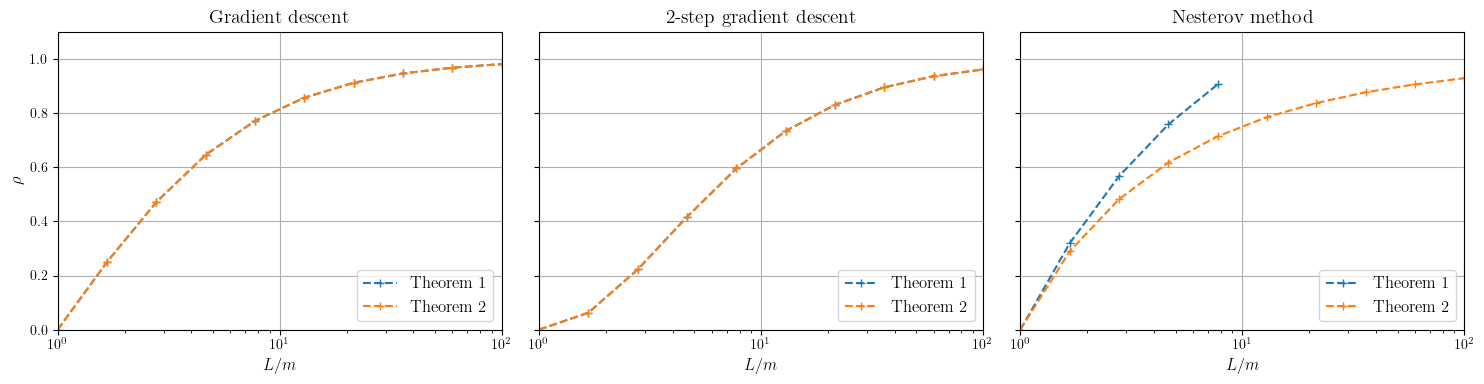

In [6]:
### Extract quantities to plot
# rhos_ogd_, rhos_nag_, rhos_ogd2_, rhos_ogd3_, rhos_ogd4_, rhos_ogd5_, rhos_tmm_ = map(lambda x: np.array([rho for rho, _ in x]), [rhos_ogd, rhos_nag, rhos_ogd2, rhos_ogd3, rhos_ogd4, rhos_ogd5, rhos_agd])
rhos_gd_thm1_, rhos_gd_thm2_  = map(lambda x: np.array([rho for rho, _ in x]), [rhos_gd_thm1, rhos_gd_thm2])
rhos_nm_thm1_, rhos_nm_thm2_, = map(lambda x: np.array([rho for rho, _ in x]), [rhos_nm_thm1, rhos_nm_thm2])
rhos_2gd_thm1_, rhos_2gd_thm2_, = map(lambda x: np.array([rho for rho, _ in x]), [rhos_2gd_thm1, rhos_2gd_thm2])
tableau10 = plt.get_cmap('tab10').colors


fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)

# Plot gradient descent
axes[0].semilogx(L_range[rhos_gd_thm1_ <= 1], rhos_gd_thm1_[rhos_gd_thm1_ <= 1],
                 '--+', label='Theorem 1', color=tableau10[0])
axes[0].semilogx(L_range[rhos_gd_thm2_ <= 1], rhos_gd_thm2_[rhos_gd_thm2_ <= 1],
                 '--+', label='Theorem 2', color=tableau10[1])
axes[0].set_title("Gradient descent")
axes[0].set_xlabel(r'$L/m$')
axes[0].set_ylabel(r'$\rho$')
axes[0].set_xlim([1, 100])
axes[0].set_ylim([0, 1.1])
axes[0].grid()
axes[0].legend(loc='lower right')

# Plot 2-step gradient descent
axes[1].semilogx(L_range[rhos_2gd_thm1_ <= 1], rhos_2gd_thm1_[rhos_2gd_thm1_ <= 1],
                 '--+', label='Theorem 1', color=tableau10[0])
axes[1].semilogx(L_range[rhos_2gd_thm2_ <= 1], rhos_2gd_thm2_[rhos_2gd_thm2_ <= 1],
                 '--+', label='Theorem 2', color=tableau10[1])
axes[1].set_title("2-step gradient descent")
axes[1].set_xlabel(r'$L/m$')
axes[1].set_xlim([1, 100])
axes[1].grid()
axes[1].legend(loc='lower right')

# Plot nesterov
axes[2].semilogx(L_range[rhos_nm_thm1_ <= 1], rhos_nm_thm1_[rhos_nm_thm1_ <= 1],
                 '--+', label='Theorem 1', color=tableau10[0])
axes[2].semilogx(L_range[rhos_nm_thm2_ <= 1], rhos_nm_thm2_[rhos_nm_thm2_ <= 1],
                 '--+', label='Theorem 2', color=tableau10[1])
axes[2].set_title("Nesterov method")
axes[2].set_xlabel(r'$L/m$')
axes[2].set_xlim([1, 100])
axes[2].grid()
axes[2].legend(loc='lower right')

plt.tight_layout()
plt.show()

### Observations:

- for gradient-based methods, Theorem 5.2 is already sufficient to get a tight result
- for accelerated methods, Theorem 5.3 offers substantial improvements

# 2 - Comparison of algorithms

## 2a) Decay rate $\rho$

In [17]:
L_range = np.logspace(0, 2, 10)

rhos_ogd, rhos_nm, rhos_tmm, rhos_2gd, rhos_5gd = [], [], [], [], []

for L in tqdm(L_range):

    ### Assume constant L (and m=1)
    grid_points = [(np.array([L]), np.array([0]))]

    ### Solve Bisection for every algorithm

    # Thm 5.2 for non-accelerated algorithms
    rho, _ = bisection_thm1(algo=gradient_descent, consistent_polytope=grid_points)
    rhos_ogd.append(rho)

    rho, _ = bisection_thm1(algo=lambda m, L: multi_step_gradient(m,L,K=5), consistent_polytope=grid_points)
    rhos_2gd.append(rho)

    rho, _ = bisection_thm1(algo=lambda m, L: multi_step_gradient(m,L,K=5), consistent_polytope=grid_points)
    rhos_5gd.append(rho)

    # Thm 5.3 for accelerated algorithms
    rho, _ = bisection_thm2(algo=nesterov, consistent_polytope=grid_points)
    rhos_nm.append(rho)

    rho, _ = bisection_thm2(algo=triple_momentum, consistent_polytope=grid_points)
    rhos_tmm.append(rho)


100%|██████████| 10/10 [00:36<00:00,  3.62s/it]


In [ ]:
L_range = np.logspace(np.log10(1/0.8 + 1e-3), 2, 10)

rhos_ogd, rhos_nag, rhos_tmm = [], [], []

n_grid = 2

for L in tqdm(L_range):

    ### Create consistent polytope grid over parameters
    L_min, L_max = L * 0.8, L
    grid_step = (L_max - L_min) / n_grid

    params = np.linspace(L_min, L_max, n_grid + 1)
    delta_L_max = lambda rate_bound: rate_bound * (L_max - L_min)

    grid_points = consistent_polytope_nd(params, -delta_L_max(rate_bound=0.05), delta_L_max(rate_bound=0.05), step_size=grid_step)

    ### Solve Bisection for every algorithm
    rho, sol = ta.bisection_thm2(algo=gradient_descent, consistent_polytope=grid_points, optimize_sensitivities=True)
    rhos_ogd.append((rho, sol))

    rho, sol = ta.bisection_thm2(algo=nesterov, consistent_polytope=grid_points, optimize_sensitivities=True)
    rhos_nag.append((rho, sol))

    rho, sol = ta.bisection_thm2(algo=triple_momentum, consistent_polytope=grid_points, optimize_sensitivities=True)
    rhos_tmm.append((rho, sol))


In [ ]:
rhos_nag, rhos_ogd, rhos_tmm
# L_range

### Plot of decay rate $\rho$

In [ ]:
### Extract quantities to plot
rhos_ogd_, rhos_nm_, rhos_tmm_ = map(lambda x: np.array([rho for rho in x]), [rhos_ogd, rhos_nm, rhos_tmm])
rhos_2gd_, rhos_5gd_ = map(lambda x: np.array([rho for rho in x]), [rhos_2gd, rhos_5gd])
tableau10 = plt.get_cmap('tab10').colors

### Plot results
plt.semilogx(L_range[rhos_ogd_ <= 1], rhos_ogd_[rhos_ogd_ <= 1], '--+', label=r'Gradient descent', color=tableau10[0])
plt.semilogx(L_range[rhos_nm_ <= 1],  rhos_nm_[rhos_nm_ <= 1], '--+',   label=r'Nesterov', color=tableau10[1])
plt.semilogx(L_range[rhos_tmm_ <= 1], rhos_tmm_[rhos_tmm_ <= 1], '--*', label=r'Triple-Momentum', color=tableau10[2])
plt.semilogx(L_range[rhos_2gd_ <= 1], rhos_2gd_[rhos_2gd_ <= 1], '--+', label=r'2-Step GD', color=tableau10[3])
plt.semilogx(L_range[rhos_5gd_ <= 1], rhos_5gd_[rhos_5gd_ <= 1], '--*', label=r'5-step GD', color=tableau10[4])

plt.xlabel(r'$L/m$')
plt.ylabel(r'$\rho$')

plt.xlim([1,100])
plt.ylim([0,1.1])

plt.legend(loc='lower right')
plt.grid()
plt.show()


## 2b) Sensitivities 

- $\gamma_f$: Sensitivitiy to function variation
- $\gamma_x$: Sensitivitiy to minimizer variation
- $\gamma_\delta$: Sensititivity to gradient variation

In [ ]:
L_range = np.logspace(0, 2, 10)

sol_gd, sol_nm, sol_tmm, sol_2gd, sol_5gd = [], [], [], [], []

for L in tqdm(L_range):

    ### Assume constant L (and m=1)
    grid_points = [(np.array([L]), np.array([0]))]

    ### Solve with Thm 5.3 to obtain sensitivities
    rho, bound_constants = bisection_thm2(algo=gradient_descent, consistent_polytope=grid_points)
    sol_gd.append((rho, bound_constants))

    rho, bound_constants = bisection_thm2(algo=lambda m, L: multi_step_gradient(m,L,K=2), consistent_polytope=grid_points)
    sol_2gd.append((rho, bound_constants))

    rho, bound_constants = bisection_thm2(algo=lambda m, L: multi_step_gradient(m,L,K=5), consistent_polytope=grid_points)
    sol_5gd.append((rho, bound_constants))

    rho, bound_constants = bisection_thm2(algo=nesterov, consistent_polytope=grid_points)
    sol_nm.append((rho, bound_constants))

    rho, bound_constants = bisection_thm2(algo=triple_momentum, consistent_polytope=grid_points)
    sol_tmm.append((rho, bound_constants))

In [ ]:
# Extract rhos
rhos_gd_, rhos_2gd_, rhos_5gd_, rhos_nm_, rhos_tmm_ = map(
    lambda x: np.array([rho for rho, _ in x]),
    [sol_gd, sol_2gd, sol_5gd, sol_nm, sol_tmm]
)

# Extract gamma_f
gamma_f_gd_  = np.array([bp[1] for _, bp in sol_gd]).flatten()  * (L_range-1) * rhos_gd_**2
gamma_f_2gd_ = np.array([bp[1] for _, bp in sol_2gd]).flatten() * (L_range-1) * rhos_2gd_**2
gamma_f_5gd_ = np.array([bp[1] for _, bp in sol_5gd]).flatten() * (L_range-1) * rhos_5gd_**2
gamma_f_nm_  = np.array([bp[1] for _, bp in sol_nm]).flatten()  * (L_range-1) * rhos_nm_**2
gamma_f_tmm_ = np.array([bp[1] for _, bp in sol_tmm]).flatten() * (L_range-1) * rhos_tmm_**2

# Extract gamma_x
gamma_x_gd_  = np.array([bp[2] for _, bp in sol_gd])
gamma_x_2gd_ = np.array([bp[2] for _, bp in sol_2gd])
gamma_x_5gd_ = np.array([bp[2] for _, bp in sol_5gd])
gamma_x_nm_  = np.array([bp[2] for _, bp in sol_nm])
gamma_x_tmm_ = np.array([bp[2] for _, bp in sol_tmm])

# Extract gamma_d
gamma_d_gd_  = np.array([bp[3] for _, bp in sol_gd])
gamma_d_2gd_ = np.array([bp[3] for _, bp in sol_2gd])
gamma_d_5gd_ = np.array([bp[3] for _, bp in sol_5gd])
gamma_d_nm_  = np.array([bp[3] for _, bp in sol_nm])
gamma_d_tmm_ = np.array([bp[3] for _, bp in sol_tmm])

# Plot
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=True)
tableau10 = plt.get_cmap('tab10').colors

# --- First subplot: gamma_f ---
axes[0].semilogx(L_range, gamma_f_gd_, '--+', label='Gradient descent', color=tableau10[0])
axes[0].semilogx(L_range, gamma_f_nm_, '--+', label='Nesterov', color=tableau10[1])
axes[0].semilogx(L_range, gamma_f_tmm_, '--*', label='Triple Momentum', color=tableau10[2])
axes[0].semilogx(L_range, gamma_f_2gd_, '--+', label='2-Step GD', color=tableau10[3])
axes[0].semilogx(L_range, gamma_f_5gd_, '--+', label='5-Step GD', color=tableau10[4])
axes[0].set_title(r'$\gamma_f$')
axes[0].set_xlabel(r'$L/m$')
axes[0].set_ylabel(r'$\gamma_f$')
axes[0].grid()
axes[0].legend()

# --- Second subplot: gamma_x ---
axes[1].semilogx(L_range, gamma_x_gd_, '--+', label='Gradient descent', color=tableau10[0])
axes[1].semilogx(L_range, gamma_x_nm_, '--+', label='Nesterov', color=tableau10[1])
axes[1].semilogx(L_range, gamma_x_tmm_, '--*', label='Triple Momentum', color=tableau10[2])
axes[1].semilogx(L_range, gamma_x_2gd_, '--+', label='2-Step GD', color=tableau10[3])
axes[1].semilogx(L_range, gamma_x_5gd_, '--+', label='5-Step GD', color=tableau10[4])
axes[1].set_title(r'$\gamma_x$')
axes[1].set_xlabel(r'$L/m$')
axes[1].set_ylabel(r'$\gamma_x$')
axes[1].grid()
axes[1].legend()

# --- Third subplot: gamma_d ---
axes[2].semilogx(L_range, gamma_d_gd_, '--+', label='Gradient descent', color=tableau10[0])
axes[2].semilogx(L_range, gamma_d_nm_, '--+', label='Nesterov', color=tableau10[1])
axes[2].semilogx(L_range, gamma_d_tmm_, '--*', label='Triple Momentum', color=tableau10[2])
axes[2].semilogx(L_range, gamma_d_2gd_, '--+', label='2-Step GD', color=tableau10[3])
axes[2].semilogx(L_range, gamma_d_5gd_, '--+', label='5-Step GD', color=tableau10[4])
axes[2].set_title(r'$\gamma_d$')
axes[2].set_xlabel(r'$L/m$')
axes[2].set_ylabel(r'$\gamma_d$')
axes[2].grid()
axes[2].legend()

plt.tight_layout()
plt.show()


## 3 - Varying-Parameter Setting $\overline{\nu}$

In [7]:
L_range = np.logspace(np.log10(1/0.8 + 1e-3), 2, 10)

rhos_fast_gd, rhos_middle_gd, rhos_slow_gd, rho_nom_gd = (list() for _ in range(4))
rhos_fast_nag, rhos_middle_nag, rhos_slow_nag, rho_nom_nag = (list() for _ in range(4))

n_sparse = 3

for L in tqdm(L_range):

    ### Create consistent polytope grid over parameters
    L_min, L_max = L * 0.8, L
    grid_step = (L_max - L_min) / n_sparse

    params = np.linspace(L_min, L_max, n_sparse + 1)
    delta_L_max = lambda rate_bound: rate_bound * (L_max - L_min)

    grid_points_fast = consistent_polytope_nd(params, -delta_L_max(rate_bound=1), delta_L_max(rate_bound=1), step_size=grid_step)
    grid_points_mod  = consistent_polytope_nd(params, -delta_L_max(rate_bound=0.5), delta_L_max(rate_bound=0.5), step_size=grid_step)
    grid_points_slow = consistent_polytope_nd(params, -delta_L_max(rate_bound=0.05), delta_L_max(rate_bound=0.05), step_size=grid_step)
    grid_static = [(np.array([L]), np.array([0]))]

    ### fast parameter variations
    rho, _ = ta.bisection_thm2(algo=gradient_descent, consistent_polytope=grid_points_fast, optimize_sensitivities=False)
    rhos_fast_gd.append(rho)
    rho, _ = ta.bisection_thm2(algo=nesterov, consistent_polytope=grid_points_fast, optimize_sensitivities=False)
    rhos_fast_nag.append(rho)

    ### moderate parameter variations
    rho, _ = ta.bisection_thm2(algo=gradient_descent, consistent_polytope=grid_points_mod, optimize_sensitivities=False)
    rhos_middle_gd.append(rho)
    rho, _ = ta.bisection_thm2(algo=nesterov, consistent_polytope=grid_points_mod, optimize_sensitivities=False)
    rhos_middle_nag.append(rho)

    ### slow parameter variations
    rho, _ = ta.bisection_thm2(algo=gradient_descent, consistent_polytope=grid_points_slow, optimize_sensitivities=False)
    rhos_slow_gd.append(rho)
    rho, _ = ta.bisection_thm2(algo=nesterov, consistent_polytope=grid_points_slow, optimize_sensitivities=False)
    rhos_slow_nag.append(rho)

    ### static
    rho, _ = ta.bisection_thm2(algo=gradient_descent, consistent_polytope=grid_static, optimize_sensitivities=False)
    rho_nom_gd.append(rho)
    rho, _ = ta.bisection_thm2(algo=nesterov, consistent_polytope=grid_static, optimize_sensitivities=False)
    rho_nom_nag.append(rho)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [16:10<00:00, 97.04s/it]


In [21]:
### Extract quantities to plot
# L_range, rho_nom_gd, rhos_fast_gd, rhos_middle_gd = map(np.array, [L_range, rho_nom_gd, rhos_fast_gd, rhos_middle_gd])
L_range, rho_nom_gd, rhos_fast_gd, rhos_middle_gd, rhos_slow_gd = map(np.array, [L_range, rho_nom_gd, rhos_fast_gd, rhos_middle_gd, rhos_slow_gd])
# rho_nom_nag, rhos_fast_nag, rhos_middle_nag = map(np.array, [rho_nom_nag, rhos_fast_nag, rhos_middle_nag])
rho_nom_nag, rhos_fast_nag, rhos_middle_nag, rhos_slow_nag = map(np.array, [rho_nom_nag, rhos_fast_nag, rhos_middle_nag, rhos_slow_nag])

In [23]:
tableau10 = plt.get_cmap('tab10').colors

### Plot results
plt.figure(figsize=(10,4))

# Gradient Descent
plt.subplot(1,2,1)
plt.semilogx(L_range[rhos_fast_gd <= 1],   rhos_fast_gd[rhos_fast_gd <= 1],     '--+', label=r'Fast variation ($\overline{\nu} = \nu_{\max}$)',      color=tableau10[0])
plt.semilogx(L_range[rhos_middle_gd <= 1], rhos_middle_gd[rhos_middle_gd <= 1], '--+', label=r'Mod. variation ($\overline{\nu} = 0.5\nu_{\max}$)',   color=tableau10[1])
plt.semilogx(L_range[rhos_slow_gd <= 1],   rhos_slow_gd[rhos_slow_gd <= 1],     '--*', label=r'Slow variation ($\overline{\nu} = 0.05\nu_{\max}$)',  color=tableau10[2])
plt.semilogx(L_range[rho_nom_gd <= 1],     rho_nom_gd[rho_nom_gd <= 1],         '--*', label=r'Nominal',                                            color=tableau10[3])

plt.xlabel(r'$L/m$')
plt.ylabel(r'$\rho$')
plt.xlim([1, 100])
plt.ylim([0, 1.1])
plt.legend(loc='lower right')
plt.grid()
plt.title('Gradient descent')

# Nesterov
plt.subplot(1,2,2)
plt.semilogx(L_range[rhos_fast_nag <= 1],   rhos_fast_nag[rhos_fast_nag <= 1],     '--+', label=r'Fast variation ($\overline{\nu} = \nu_{\max}$)',      color=tableau10[0])
plt.semilogx(L_range[rhos_middle_nag <= 1], rhos_middle_nag[rhos_middle_nag <= 1], '--+', label=r'Mod. variation ($\overline{\nu} = 0.5\nu_{\max}$)',   color=tableau10[1])
plt.semilogx(L_range[rhos_slow_nag <= 1],   rhos_slow_nag[rhos_slow_nag <= 1],     '--*', label=r'Slow variation ($\overline{\nu} = 0.05\nu_{\max}$)',  color=tableau10[2])
plt.semilogx(L_range[rho_nom_nag <= 1],     rho_nom_nag[rho_nom_nag <= 1],         '--*', label=r'Nominal',                                            color=tableau10[3])

plt.xlabel(r'$L/m$')
plt.ylabel(r'$\rho$')
plt.xlim([1, 100])
plt.ylim([0, 1.1])
plt.legend(loc='lower right')
plt.grid()
plt.title('Nesterov')

plt.show()


4 - Algorithms for constrained optimization